# Exploratory Data Analysis

## Objectives 

* Determine the shape of the annotation data.
* Identify class balance.
* Examine image metadata.
* Visualize images.
* Visualize bounding boxes.
* Get the mean pixel intensity of all images, to set as a parameter for Mask R-CNN.

## Data

* Radiological Society of North America (RSNA) 2018 Challenge dataset.
* All data used for this notebook were stored locally at `/projects/lungbox`, and on Amazon S3. These data have not been committed with the `lungbox` repo. However, a small subset of example data is also included with this project.

In [110]:
import os
import sys
import time
import random
import numpy as np
import pandas as pd
import pylab
import pydicom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pathlib

try:
    script_path = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_path = "/projects/lungbox/src"
    sys.path.append(script_path)
sys.path.append(script_path + "/Mask_RCNN")

In [3]:
%matplotlib inline 
IS_LOCAL = False

In [9]:
%cd /projects/lungbox

/projects/lungbox


## Findings

### Annotation Data

* About 22% of patients in the dataset have pneumonia.
* 33% are normal. The remaining 45% do not present visual evidence of pneumonia, but are not normal.
* Only patients with evidence of pneumonia have bounding boxes.
  * All bounding boxes have `x`, `y`, `width`, and `height` attributes available.
* Up to 4 bounding boxes may be present for a given patient.
  * The vast majority of pneumonia patients, however, only have one box.

In [49]:
# Load class info
class_df = pd.read_csv('data/raw/stage_1_detailed_class_info.csv')
class_df.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [51]:
# Tabulate class info classes
print(class_df.groupby('class').size() / class_df.shape[0])

class
Lung Opacity                    0.309221
No Lung Opacity / Not Normal    0.396702
Normal                          0.294077
dtype: float64


In [42]:
# Tabulate class info without duplicate patients
class_nodup_df = class_df.drop_duplicates()
print(class_nodup_df.groupby('class').size() / class_nodup_df.shape[0])

class
Lung Opacity                    0.220332
No Lung Opacity / Not Normal    0.447750
Normal                          0.331919
dtype: float64


In [52]:
# Examine bounding box data
annotation_df = pd.read_csv('data/raw/stage_1_train_labels.csv')
print('# of unique bound boxes: {}'.format(annotation_df.shape[0]))
print('# of unique patients: {}'.format(annotation_df['patientId'].nunique()))
annotation_df.head(10)

# of unique bound boxes: 28989
# of unique patients: 25684


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [57]:
# Check annotation group class sizes
print(annotation_df.groupby('Target').size() / annotation_df.shape[0])

Target
0    0.690779
1    0.309221
dtype: float64


In [55]:
# Check if having a bounding box is one-to-one with having pneumonia
train_df = pd.concat([annotation_df, class_df.drop(labels=['patientId'], axis=1)], axis=1)
train_df.groupby(['class', 'Target']).size()

class                         Target
Lung Opacity                  1          8964
No Lung Opacity / Not Normal  0         11500
Normal                        0          8525
dtype: int64

In [53]:
# Check if all bounding box attributes are present for pneumonia patients
train_df.loc[train_df['Target']==1, ['x', 'y', 'width', 'height']].isnull().any()

x         False
y         False
width     False
height    False
dtype: bool

In [67]:
# Count the number of boxes by patient
annotation_df.groupby('patientId').size() \
    .reset_index(name='counts') \
    .groupby('counts').size()

counts
1    22506
2     3062
3      105
4       11
dtype: int64

### Image Data

* The mean pixel intensity can be approximated to 255/2 = 127.5. This is a tuning parameter for an R-CNN.
* The width of a bounding box can be as small as 40 pixels. This is also useful to know for tuning an R-CNN.

In [75]:
patient_id = annotation_df['patientId'][0]
dcm_file = 'data/raw/stage_1_train_images/{}.dcm'.format(patient_id)
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [106]:
def display_training_image(df, patient_id):
    dcm_file = 'data/raw/stage_1_train_images/{}.dcm'.format(patient_id)
    dcm_data = pydicom.read_file(dcm_file)
    dcm_image = dcm_data.pixel_array
    boxes = df.loc[df['patientId']==patient_id][['x', 'y', 'width', 'height', 'Target', 'class']].values
    plt.figure(figsize=(10, 5))
    plt.imshow(dcm_image, cmap=pylab.cm.binary)
    plt.axis('off')
    
    class_color_dict = {'Normal': 'green',
                        'No Lung Opacity / Not Normal': 'orange',
                        'Lung Opacity': 'red'}

    if len(boxes) > 0:
        for box in boxes:
            # extract individual coordinates and labels
            x, y, w, h, t, c = box 
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red', 
                              fill=False, lw=2, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            plt.gca().add_patch(patch)
            
    # add annotation text
    plt.text(10, 50, c, color=class_color_dict[c], size=15, 
             bbox=dict(edgecolor=class_color_dict[c], facecolor='none', alpha=0.5, lw=2))

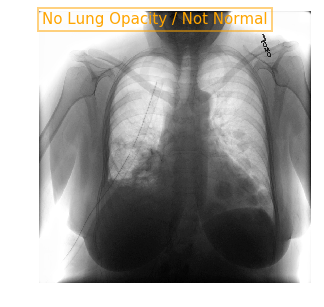

In [107]:
display_training_image(df=train_df, patient_id='0004cfab-14fd-4e49-80ba-63a80b6bddd6')

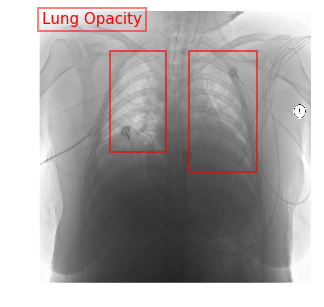

In [108]:
display_training_image(df=train_df, patient_id='00436515-870c-4b36-a041-de91049b9ab4')

In [114]:
# Get mean intensity of all images
mean_intensity = []
pathlist = pathlib.Path('/projects/lungbox/data/raw/stage_1_train_images').glob('**/*.dcm')
for path in pathlist:
    dcm_data = pydicom.read_file(str(path))
    im = dcm_data.pixel_array
    mean_intensity.append(im.mean())
    
    # Break to avoid a long computation.
    # Assume that the first 1000 images are representative
    if (len(mean_intensity) == 1000):
        break
print(np.mean(mean_intensity))  # 125.65597050857544 -- close enough to 255/2 = 127.5

125.65597050857544


In [115]:
# Create training dataset
from data import TrainingData
data = TrainingData(data_source='local',
                    subdir='train',
                    subset_size=25684, # total number of patients
                    validation_split=0.2)

Using TensorFlow backend.


Using cached image list: data/preprocessed/local_dicom_image_list.csv
Training count: 20548
Validation instance count: 5136


In [116]:
# Collect all bounding boxes
all_boxes = []
for k, v in data.annotation_dict.items():
    boxes = v['boxes']
    if len(boxes) > 0:
        for box in boxes:
            all_boxes.append(box)
all_widths = [x[2] for x in all_boxes]
all_heights = [x[3] for x in all_boxes]

In [117]:
print('Total number of boxes: {}'.format(len(all_boxes)))
print("Width  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(all_widths), np.median(all_widths),
    np.min(all_widths), np.max(all_widths)))
print("Height mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(all_heights), np.median(all_heights),
    np.min(all_heights), np.max(all_heights)))

Total number of boxes: 8964
Width  mean: 220.85  median: 219.00  min: 40.00  max: 528.00
Height mean: 334.17  median: 304.00  min: 45.00  max: 942.00


# References

* [Intro to deep learning for medical imaging by MD.ai - RSNA Pneumonia Detection Challenge](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb)
* [RSNA Pneumonia Detection EDA](https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda)
* [Intro to Lung Opacity S1](https://www.kaggle.com/giuliasavorgnan/start-here-beginner-intro-to-lung-opacity-s1)
* [Intro EDA with DICOM Metadata](https://www.kaggle.com/jtlowery/intro-eda-with-dicom-metadata)
